In [67]:
import sounddevice as sd # reading and writing sound files
import soundfile as sf
import numpy as np # numerical operations
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import parselmouth # sound analysis
import pandas as pd # dataframe manipulation

sns.set(context='paper', style='ticks', font_scale=1) # set the plot style

The code below can be used to install the missing librariies in Google Colab. 

In [12]:
### Uncomment the following lines to install the necessary packages ###
# !pip3 install sounddevice
# !pip3 install seaborn
# !pip3 install praat-parselmouth
# !pip3 install soundfile

## 1. Soundwave

### 1.1. Basic properties: frequency and amplitude

Let's start by generating a sound wave. For that, we need to define its frequency and amplitude. The frequency is the number of cycles per second, and the amplitude is the maximum displacement of the wave from its equilibrium position.

In [28]:
FREQUENCY = 4 # measured in Hz
AMPLITUDE = 100 # measured in relative units
DURATION = 1 # measured in seconds

Since sound is continuous, we need to record it somehow. We can sample 44100 points per second, which is the standard sampling rate for audio CDs: 

In [30]:
t = np.linspace(0, DURATION, int(44100 * DURATION), endpoint=False) # time variable (44100 samples per second)

Let's check whether t vector has the correct size:

In [31]:
t.shape

(44100,)

Let's now create the sin wave using the formula:

$$y(t) = A \sin(2\pi f t)$$

where:

- $A$ is the amplitude of the wave
- $f$ is the frequency of the wave
- $t$ is the time

Essentially it determines the position of the wave at a given time. The amplitude determines the height of the wave, and the frequency determines how many times the wave repeats in a given time frame. 2 * pi is used because the vawe can be represented as a circle.

![Sound wave](https://europe1.discourse-cdn.com/unity/original/3X/1/6/16042a63a17ef2b18ddf4b01d5e9ae26151b4845.gif)

This equation is implemented in Python below:

In [39]:
wave = AMPLITUDE * np.sin(2 * np.pi * FREQUENCY * t)
wave = wave.round(4)

Let's play it to check if it is working:

In [40]:
sd.play(wave, samplerate=44100) # play the sound using the sounddevice library
sd.wait() # wait until the sound is done playing

Let's save the wave:

In [42]:
sf.write('sine_wave_1.wav', wave, 44100) # save the wave using soundfile

Finally, let's plot the wave:

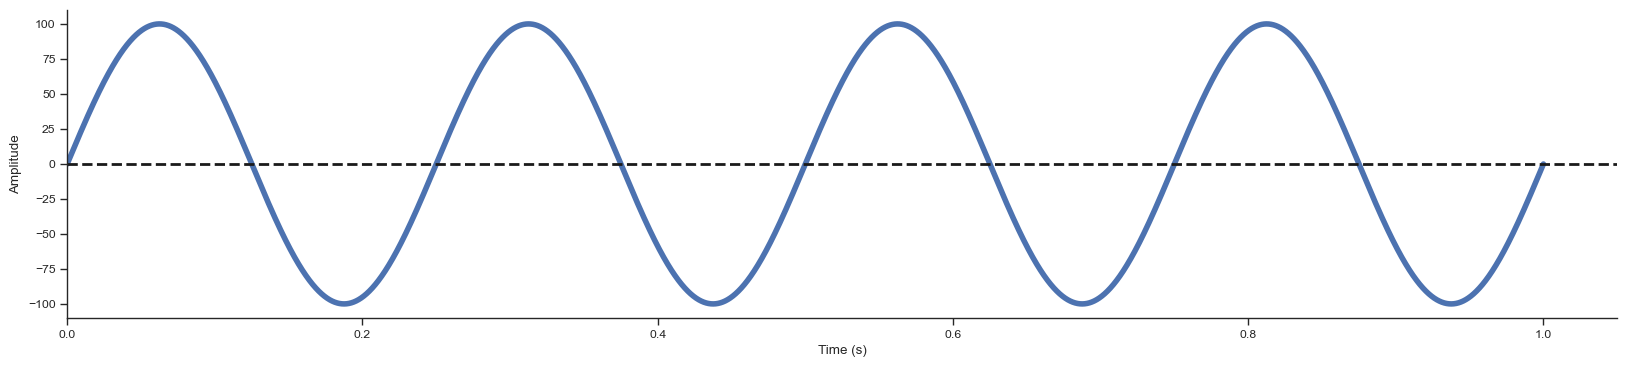

In [37]:
plt.figure(figsize=(20, 4)) # set the plot size
plt.plot(t, wave, linewidth=4) # plot the wave
plt.xlabel('Time (s)') # set the x label
plt.ylabel('Amplitude') # set the y label
plt.axhline(y=0, color='k', linestyle='--', linewidth=2) # add a horizontal line at 0
plt.xlim(-0, None) # set the x-axis limits
sns.despine() # remove the top and right spines
plt.show() # show the plot

Ok, great. Can you npow add vertical lines to the plot to show the period of the wave? Remember that frequency is the number of cycles per second, so you can extract the period points from frequency. You can use [plt.axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html) to plot vertical lines. 

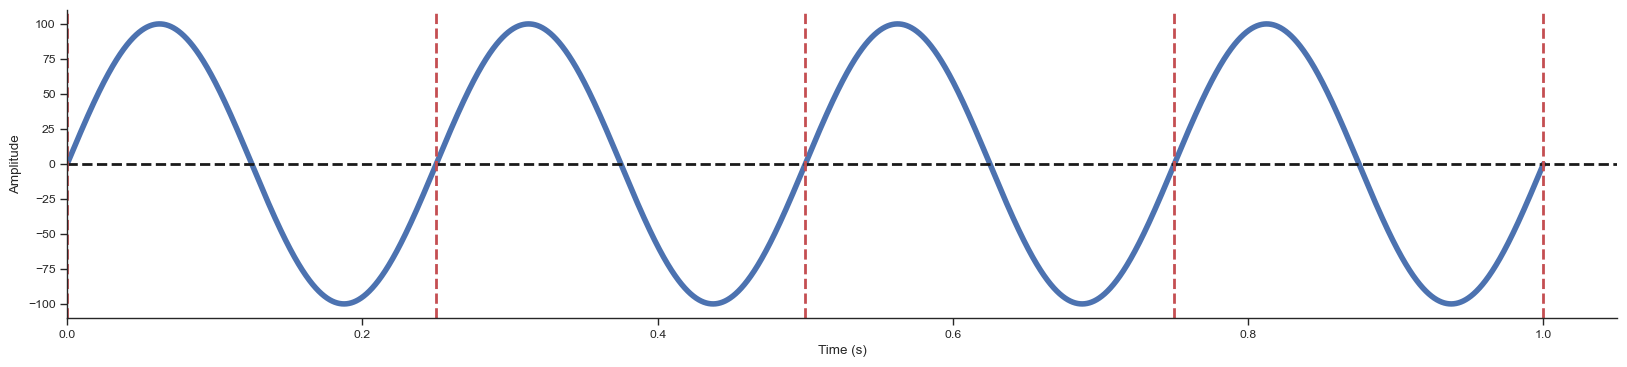

In [54]:
plt.figure(figsize=(20, 4))
plt.plot(t, wave, linewidth=4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# indicate frequency as intercection of the wave with the x-axis
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)

# Frequency is the number of full waves in one second, so 
# we can delimit the full waves by dividing the duration by the frequency.
# In our case, the duration is 1 second and the frequency is 4 Hz, so we have 4 full waves in 1 second.
for _ in range(FREQUENCY + 1): 
    plt.axvline(x=_/FREQUENCY, color='r', linestyle='--', linewidth=2)

plt.xlim(-0, None)
sns.despine()
plt.show()

We can also find the crest by finding time points where the wave value is equal to amplitude:

In [44]:
crest_y = np.where(wave == AMPLITUDE)[0] # find the values of x where the wave is at 1000
crest_x = t[crest_y][0] # get the first value of x where the wave is at 1000

Now let's plot the wave with the crest:

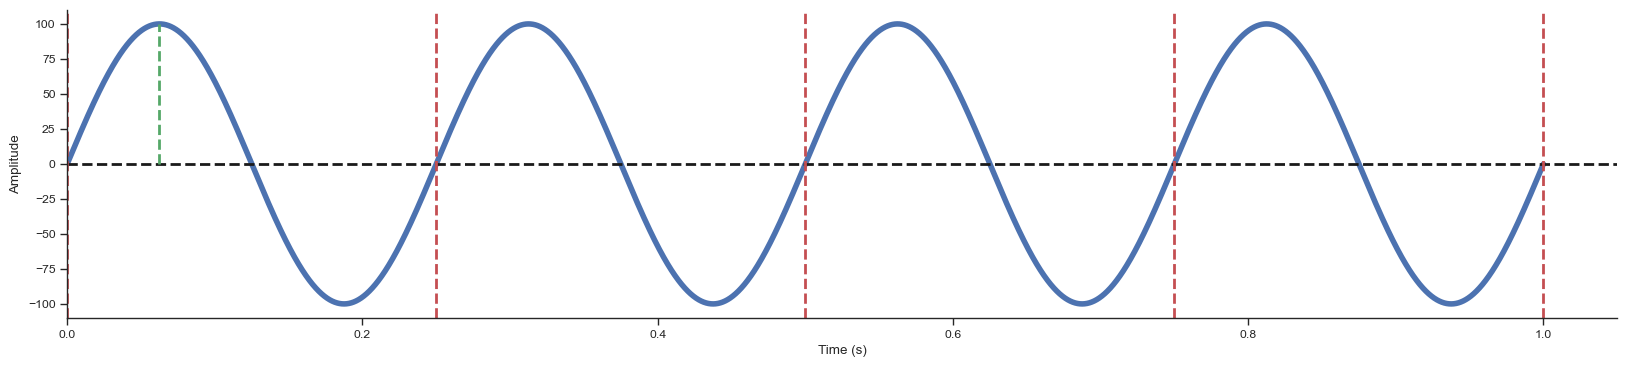

In [46]:
plt.figure(figsize=(20, 4))
plt.plot(t, wave, linewidth=4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# indicate frequency as intercection of the wave with the x-axis
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)

# delimit full waves
plt.axvline(x=0, color='r', linestyle='--')
# Frequency is the number of full waves in one second, so 
# we can delimit the full waves by dividing the duration by the frequency.
# In our case, the duration is 1 second and the frequency is 4 Hz, so we have 4 full waves in 1 second.
for _ in range(FREQUENCY + 1): 
    plt.axvline(x=_/FREQUENCY, color='r', linestyle='--', linewidth=2)

# plot the crest as a vertical line from y = 0 to the crest [crest_x, 0], [crest_x, AMPLITUDE]
plt.plot([crest_x, crest_x], [0, AMPLITUDE], 
         color='g', linestyle='--', linewidth=2)

plt.xlim(-0, None)
sns.despine()
plt.show()

### 1.2. Let's change the properties!

First, we will turn our sound generating mechanism into a function

In [47]:
def generate_sound(frequency, amplitude, duration, sample_rate = 44100):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    return amplitude * np.sin(frequency * 2 * np.pi * t)

We would also need a function to play it

In [48]:
def play_sound(sound):
    sd.play(sound, samplerate=44100)
    sd.wait()

Let's generate a sound with a higher frequency and a lower amplitude

In [49]:
c3 = generate_sound(frequency = 130, # do (C3) 
                       amplitude = 1, 
                       duration = 1)

Save the file:

In [50]:
sf.write('c3.wav', c3, 44100)

And play the sound:

In [51]:
play_sound(c3)

Finally, let's visualize the wave:

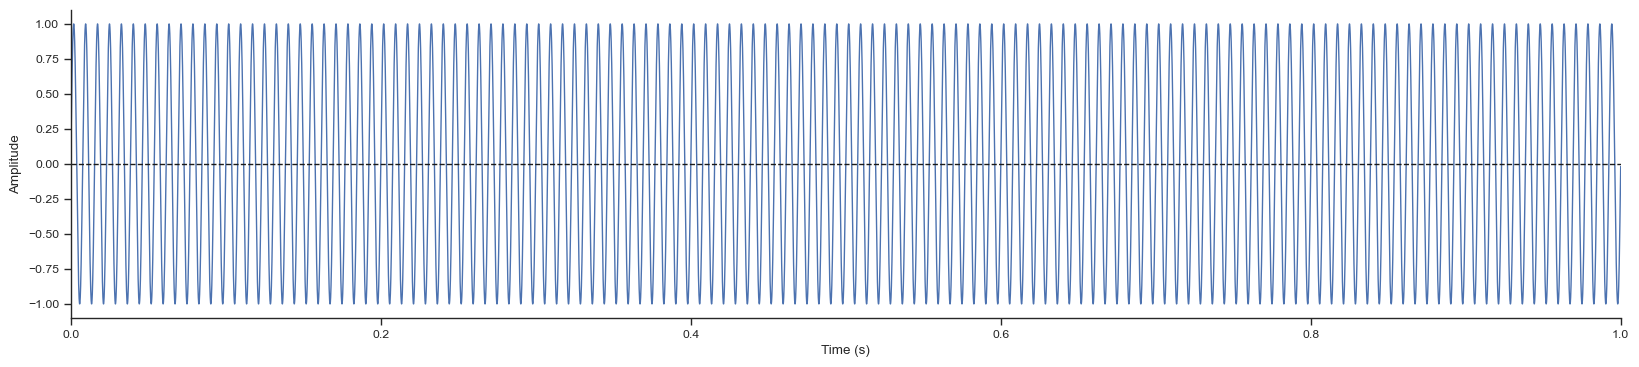

In [53]:
plt.figure(figsize=(20, 4))
plt.plot(t, c3, linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.axhline(y=0, color='k', linestyle='--', 
            linewidth=1)

plt.xlim(-0, 1)
sns.despine()

### 1.3. Combining different frequencies

Ok, now we know how to create individual waves. Let's combine them to create a more complex sound. We can do this by summing the waves:

In [61]:
# write a function to combine three frequencies at same amplitude

def generate_chord(frequencies, amplitude, duration, sample_rate = 44100):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    return amplitude * (np.sin(frequencies[0] * 2 * np.pi * t) + 
                         np.sin(frequencies[1] * 2 * np.pi * t) + 
                         np.sin(frequencies[2] * 2 * np.pi * t))

Why can we just add the waves? Let's try whether it works by generating the A minor chord:

In [62]:
a_minor = generate_chord(frequencies = [220, 262, 330], # A3, C4, E4
                       amplitude = 1, 
                       duration = 1)

Now let's also generate all the corresponding notes one by one:

In [56]:
s_220 = generate_sound(frequency = 220, # A4
                          amplitude = 1, 
                          duration = 1)
s_262 = generate_sound(frequency = 262, # C4
                            amplitude = 1, 
                            duration = 1)
s_330 = generate_sound(frequency = 330, # E4
                            amplitude = 1, 
                            duration = 1)

And write them to files:

In [20]:
sf.write('a3.wav', s_220, 44100)
sf.write('c4.wav', s_262, 44100)
sf.write('e4.wav', s_330, 44100)

Let's visualize all the 3 notes together:

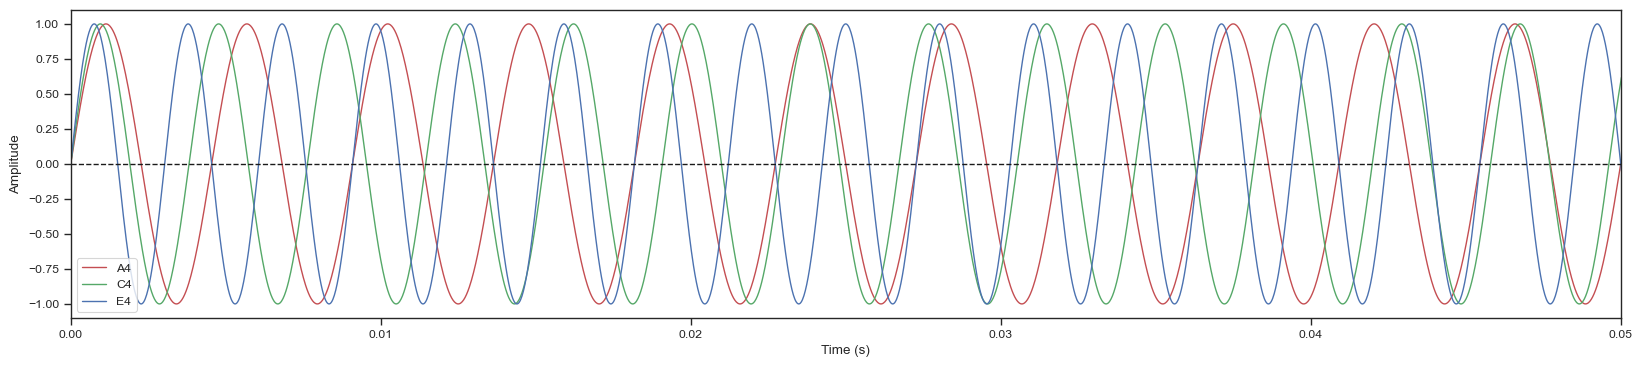

In [57]:
# plot the three sounds together
plt.figure(figsize=(20, 4))
plt.plot(t, s_220, linewidth=1, label='A4', color='r')
plt.plot(t, s_262, linewidth=1, label='C4', color='g')
plt.plot(t, s_330, linewidth=1, label='E4', color='b')
# add a line at 0
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.xlim(0, 0.05)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

And separately:

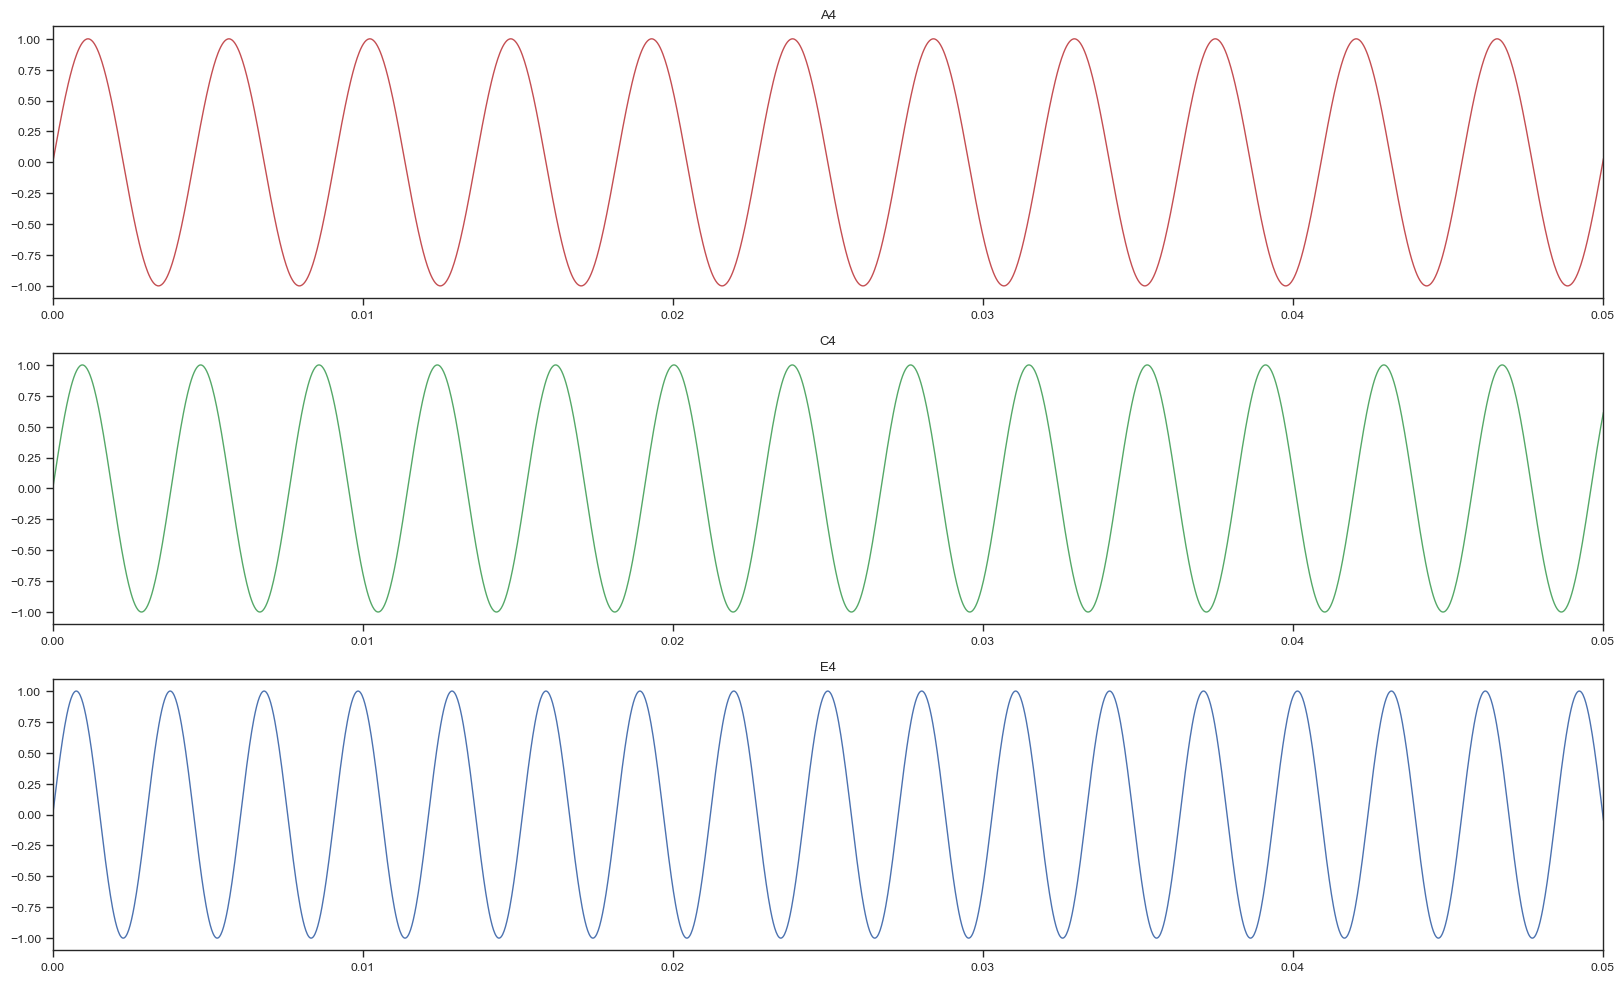

In [58]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12))
axs[0].plot(t, s_220, linewidth=1, color='r')
axs[0].set_title('A4')
axs[0].set_xlim(0, 0.05)
axs[1].plot(t, s_262, linewidth=1, color='g')
axs[1].set_title('C4')
axs[1].set_xlim(0, 0.05)
axs[2].plot(t, s_330, linewidth=1, color='b')
axs[2].set_title('E4')
axs[2].set_xlim(0, 0.05)
# xlim is the same for all subplots (0. 0.05)
plt.show()

Finally, let's plot the chord on top:

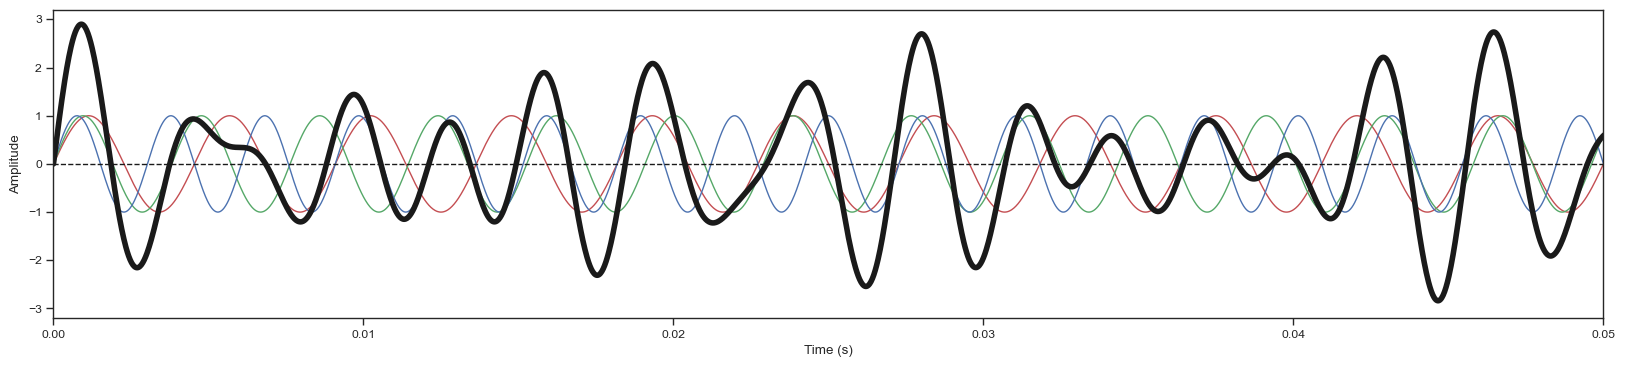

In [63]:
# plot the three sounds together
plt.figure(figsize=(20, 4))
plt.plot(t, s_220, linewidth=1, label='A4', color='r')
plt.plot(t, s_262, linewidth=1, label='C4', color='g')
plt.plot(t, s_330, linewidth=1, label='E4', color='b')
plt.plot(t, a_minor, linewidth=4, label='A minor chord', color = 'k')
# add a line at 0
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.xlim(0, 0.05)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# legend at the bottom left corner
plt.show()

In [24]:
# renormalize the chord
a_minor = a_minor / np.max(a_minor)

In [25]:
play_sound(a_minor)

In [26]:
# save all the waves using soundfile
sf.write('a_minor.wav', a_minor, 44100)

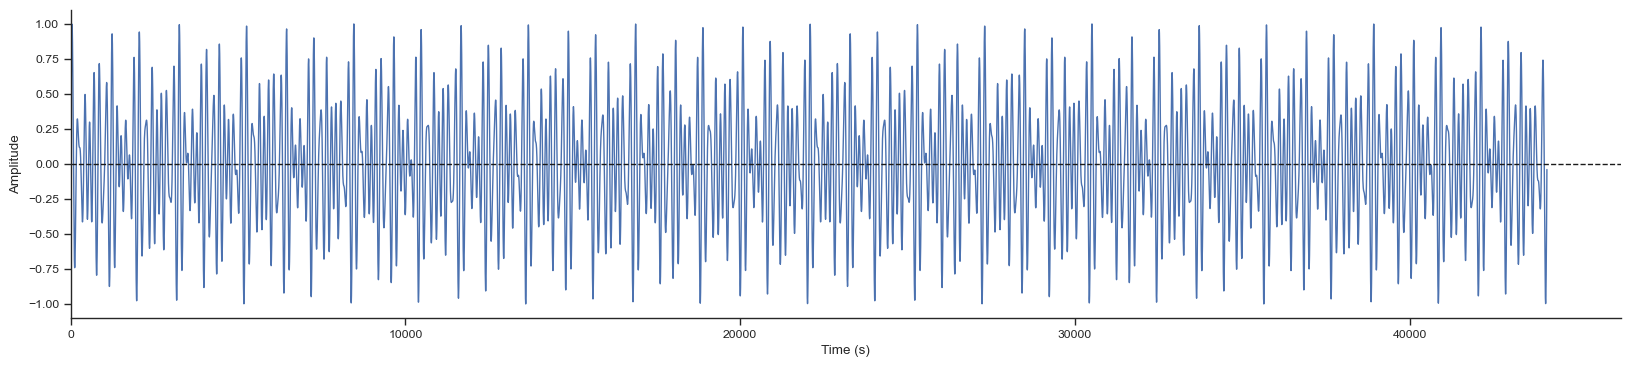

In [27]:
# visualize the sound
plt.figure(figsize=(20, 4))
plt.plot(a_minor, linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.axhline(y=0, color='k', linestyle='--', 
            linewidth=1)

plt.xlim(-0, None)
sns.despine()

In [100]:
# generate /a/ based on formants
a_vowel = generate_chord(frequencies = [710, 1100, 2540],
                       amplitude = 1, 
                       duration = 1)

In [101]:
play_sound(a_vowel)

In [106]:
# generate /u/ based on formants
u_vowel = generate_chord(frequencies = [310, 870, 2240],
                       amplitude = 1, 
                       duration = 1)

In [107]:
play_sound(u_vowel)

In [104]:
# generate /i/ based on formants
i_vowel = generate_chord(frequencies = [280, 2250, 2890], # A3, C4, E4
                       amplitude = 1, 
                       duration = 1)

In [105]:
play_sound(i_vowel)

If you want to go further, I suggest watching the following video:

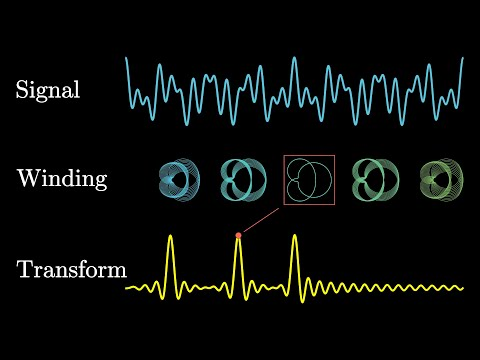

In [68]:
from IPython.display import YouTubeVideo # embedding youtube videos

YouTubeVideo('spUNpyF58BY', width=800, height=500)

## 2. Spectrograms

We will be relying on [parselmouth](https://parselmouth.readthedocs.io/en/stable/index.html) to generate the spectrograms and analyze them.

### 2.1. Spectrogram of a note

Let's plot the spectrogram of a note to understand how it works:

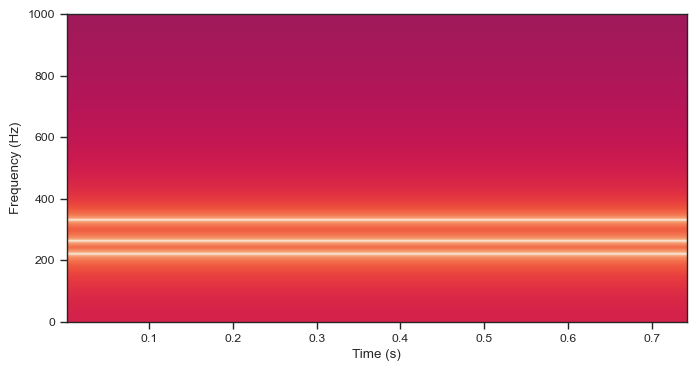

In [30]:
# convert sound to spectrogram  
plt.figure(figsize=(8, 4))
# only consider 0 -- 1000 hz
plt.specgram(a_minor, NFFT=2**15, Fs=44100) # 2**15 is the number of samples per window
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, 1000)
plt.show()

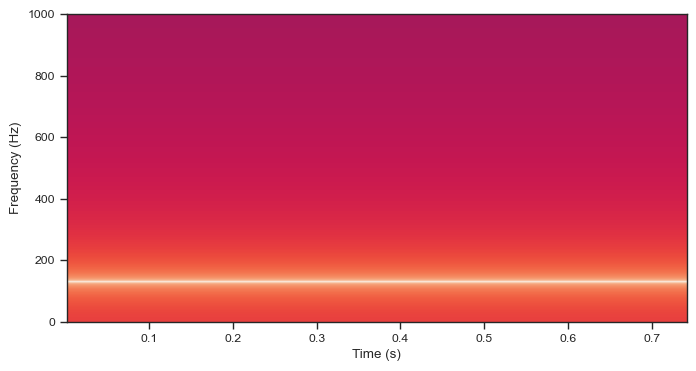

In [31]:
plt.figure(figsize=(8, 4))
# only consider 0 -- 1000 hz
plt.specgram(c3, NFFT=2**15, Fs=44100) # 2**15 is the number of samples per window
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, 1000)
plt.show()

### 2.2. Spectrogram of speech

Let's read our file first:

In [32]:
snd = parselmouth.Sound('data/ta-ta-ta.wav')

We can use our previously written function to play the sound:

In [65]:
play_sound(snd.values[0])

Let's plot the speech signal as a function of time and amplitude

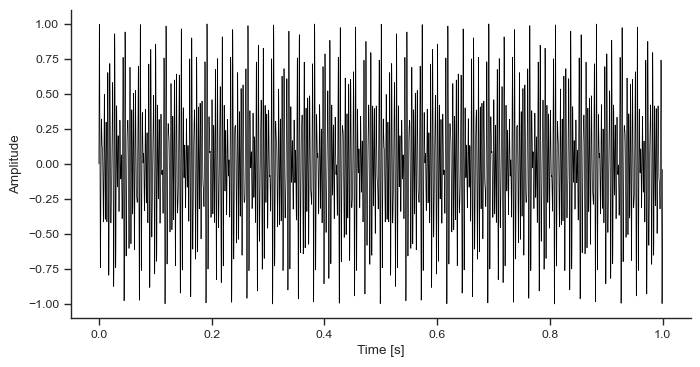

In [66]:
plt.figure(figsize=(8, 4)) # define the figure size
plt.plot(snd.xs(), snd.values.T, 
         linewidth=0.5, color='black') # plot the amplitude as a function of time
plt.xlabel("Time [s]") # set the x-axis label
plt.ylabel("Amplitude") # set the y-axis label
sns.despine() # remove the top and right spines (just for aesthetics)
plt.show() 

Let's create a function to plot the spectrogram:

In [35]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid() # get the x and y coordinates
    sg_db = 10 * np.log10(spectrogram.values) # convert the intensity to dB
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='Greys') # plot the spectrogram
    plt.ylim([0, 5000]) # let's limit the spectrogram to 5000 Hz (range of human voice)
    plt.xlabel("Time [s]") # set the x-axis label
    plt.ylabel("Frequency [Hz]") # set the y-axis label

Converting the signal to a spectrogram:

In [36]:
spectrogram = snd.to_spectrogram()

Plotting the spectrogram:

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_16119/3585317524.py:3: RuntimeWarning: divide by zero encountered in log10
  sg_db = 10 * np.log10(spectrogram.values) # convert the intensity to dB


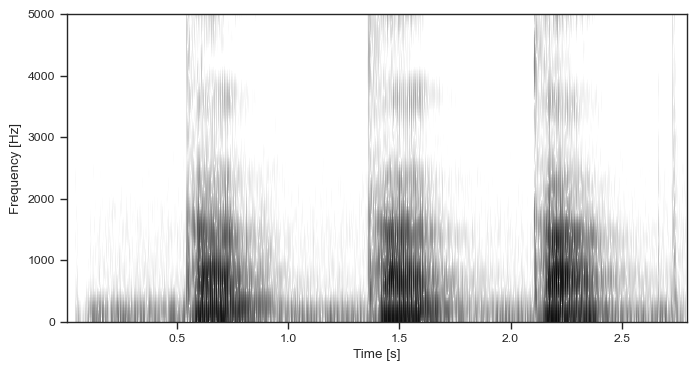

In [37]:
plt.figure(figsize=(8, 4))
draw_spectrogram(spectrogram)
plt.show()

Now we can add pitch contours to the spectrogram. Let's extract the pitch contour first:

In [38]:
pitch = snd.to_pitch()

In [39]:
def draw_pitch(pitch):
    pitch_values = pitch.selected_array['frequency'] # extract the pitch values
    pitch_values[pitch_values==0] = np.nan # set 0 values to NaN for better plotting
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='red') # plot the pitch values
    plt.ylim(0, pitch.ceiling) # limit the y-axis to the possible pitch range
    plt.ylabel("Fundamental frequency [Hz]") # set the y-axis label

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_16119/3585317524.py:3: RuntimeWarning: divide by zero encountered in log10
  sg_db = 10 * np.log10(spectrogram.values) # convert the intensity to dB


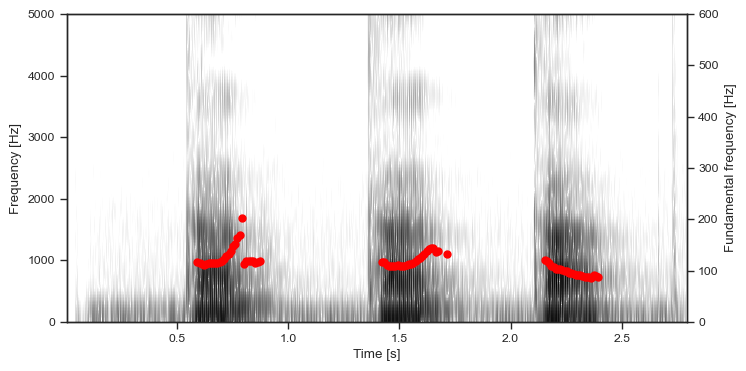

In [40]:
plt.figure(figsize=(8, 4)) # define the figure size
draw_spectrogram(spectrogram) # plot the spectrogram
plt.twinx() # create a twin Axes sharing the xaxis (to plot fundamental frequency for pitch)
draw_pitch(pitch) # plot the pitch
plt.show() # show the plot

Why do we only have pitch values for some of the frames? Because pitch depends on voicing (it's the lowest frequency in the spectrum when the vocal folds are vibrating). When the vocal folds are not vibrating, we don't have a pitch value.

## 3. Replication of Winter et al. (2022)

### 3.1. Reading and cleaning the data

Let's read the data first.

In [41]:
data = pd.read_csv('data/final_data_winter_2022.csv', sep=',', header=0).rename_axis('Form').reset_index()

Let's look at the data. What columns do you see?

In [42]:
data.head(10)

,Form,Language,ISO_code,Phoible_code,Meaning,Trill,Dataset,Latitude,Longitude,Family,Branch,Area,Continent,Rough.M,rough,R_type,r,l,Meaning.f
0,0,Azeerbaijani,aze,azj,‘rough’,no,Google,40.50,48.50,Turkic,Common Turkic,Greater Mesopotamia,W and SW Eurasia,6.2,True,no trill,False,False,‘rough’
1,1,Basque,eus,eus,‘rough’,yes,Google,43.00,-3.00,Basque,NaN,Europe,W and SW Eurasia,6.2,True,mixed with trill,True,False,‘rough’
2,2,Haitian Creole,hat,hat,‘rough’,no,Google,19.00,-72.50,Haitian Creole,NaN,Mesoamerica,C America,6.2,True,NaN,True,False,‘rough’
3,3,Hebrew,heb,heb,‘rough’,no,Google,31.50,34.83,Semitic,West Semitic,Greater Mesopotamia,W and SW Eurasia,6.2,True,no rhotic,False,False,‘rough’
4,4,Georgian,kat,kat,‘rough’,yes,Google,42.00,44.00,Kartvelian,Georgian-Zan,Greater Mesopotamia,W and SW Eurasia,6.2,True,trill,False,False,‘rough’
5,5,Mongolian,mon,khk,‘rough’,yes,Google,49.00,117.00,Mongolic,NaN,Inner Asia,N-C Asia,6.2,True,trill,True,False,‘rough’
6,6,Malay,mly,zsm,‘rough’,yes,Google,3.00,102.00,Austronesian,Malayo-Polynesian,Southeast Asia,S/SE Asia,6.2,True,trill,True,False,‘rough’
7,7,Maltese,mlt,mlt,‘rough’,yes,Google,35.92,14.42,Semitic,West Semitic,Europe,W and SW Eurasia,6.2,True,trill,False,False,‘rough’
8,8,Sundanese,sun,sun,‘rough’,no,Google,-7.00,107.00,Austronesian,Malayo-Polynesian,Southeast Asia,S/SE Asia,6.2,True,no trill,True,False,‘rough’
9,9,Tagalog (Filipino),tgl,tgl,‘rough’,no,Google,15.00,121.00,Austronesian,Malayo-Polynesian,Oceania,S/SE Asia,6.2,True,no trill,False,False,‘rough’


Let's look at the contents of the R_type column:

In [43]:
data.R_type.unique()

array(['no trill', 'mixed with trill', nan, 'no rhotic', 'trill'],
      dtype=object)

Let's remove the N.A. values from this column:

In [44]:
data.dropna(subset=['R_type'], inplace=True)

Checking that we correctly removed N.A. values:

In [45]:
data.R_type.unique()

array(['no trill', 'mixed with trill', 'no rhotic', 'trill'], dtype=object)

First, we need to modify the R_type column, to convert it into binary (trill / other) and then we can proceed with the analysis. We will store the new values in the *R_type_binary* column.

In [46]:
data['R_type_bin'] = data.R_type.apply(lambda x: 'trill' if x == 'trill' else 'other')

Let's check the results of the transformation:

In [47]:
data['R_type_bin'].unique()

array(['other', 'trill'], dtype=object)

### 3.2. Analysing languages with trills only

We will start by looking at languages that only have trilled /r/ sounds.

In [48]:
data_trill_only = data[data.R_type_bin == 'trill']

Checking that the dataset is fine:

In [49]:
data_trill_only.head(10)

,Form,Language,ISO_code,Phoible_code,Meaning,Trill,Dataset,Latitude,Longitude,Family,Branch,Area,Continent,Rough.M,rough,R_type,r,l,Meaning.f,R_type_bin
4,4,Georgian,kat,kat,‘rough’,yes,Google,42.000000,44.000000,Kartvelian,Georgian-Zan,Greater Mesopotamia,W and SW Eurasia,6.2,True,trill,False,False,‘rough’,trill
5,5,Mongolian,mon,khk,‘rough’,yes,Google,49.000000,117.000000,Mongolic,NaN,Inner Asia,N-C Asia,6.2,True,trill,True,False,‘rough’,trill
6,6,Malay,mly,zsm,‘rough’,yes,Google,3.000000,102.000000,Austronesian,Malayo-Polynesian,Southeast Asia,S/SE Asia,6.2,True,trill,True,False,‘rough’,trill
7,7,Maltese,mlt,mlt,‘rough’,yes,Google,35.920000,14.420000,Semitic,West Semitic,Europe,W and SW Eurasia,6.2,True,trill,False,False,‘rough’,trill
12,12,Pitta-Pitta,pit,pit,‘rough’,yes,Chirila,-23.870327,139.675189,Pama-Nyungan,Karnic,S Australia,Australia,6.2,True,trill,True,False,‘rough’,trill
14,14,Ritharrngu,rit,rit,‘rough’,yes,Chirila,-13.091347,136.038424,Pama-Nyungan,Yolngu,N Australia,Australia,6.2,True,trill,True,False,‘rough’,trill
15,15,Woiwurrung,wyi,wyi,‘rough’,yes,Chirila,-37.642645,145.587996,Pama-Nyungan,Kulinic,S Australia,Australia,6.2,True,trill,False,True,‘rough’,trill
32,32,Gupapuyngu,guf,guf,‘rough’,yes,Chirila,-12.717258,135.881906,Pama-Nyungan,Yolngu,N Australia,Australia,6.2,True,trill,True,False,‘rough’,trill
34,34,Bandjalang,bdy,bdy,‘rough’,yes,Chirila,-28.705397,152.988994,Pama-Nyungan,Bandjalangic,S Australia,Australia,6.2,True,trill,False,False,‘rough’,trill
35,35,Bandjalang,bdy,bdy,‘rough’,yes,Chirila,-28.705397,152.988994,Pama-Nyungan,Bandjalangic,S Australia,Australia,6.2,True,trill,True,False,‘rough’,trill


We need to count the average amount of trills per meaning type ('rough' or 'smooth') for each language.

In [50]:
# make a summary table
summary = data_trill_only.groupby(['Family', 'Trill', 'Meaning']).agg({'r': 'mean', 'Form': 'count'}).reset_index()
# make form a float
summary['Form'] = summary['Form'].astype(float)
# convert to percentage
summary['r'] = summary['r'] * 100

Let's look at our new dataset:

In [51]:
summary.head(10)

,Family,Trill,Meaning,r,Form
0,Austroasiatic,yes,‘rough’,57.142857,7.0
1,Austroasiatic,yes,‘smooth’,0.000000,6.0
2,Austronesian,yes,‘rough’,68.181818,22.0
3,Austronesian,yes,‘smooth’,22.222222,45.0
4,Barbacoan,yes,‘smooth’,0.000000,1.0
5,Benue-Congo,yes,‘rough’,100.000000,1.0
6,Benue-Congo,yes,‘smooth’,0.000000,1.0
7,Berber,yes,‘rough’,0.000000,1.0
8,Berber,yes,‘smooth’,0.000000,1.0
9,Central Solomons,yes,‘smooth’,0.000000,3.0


How many languages does it contain?

In [52]:
### YOUR ANSWER HERE ### 

Let's plot the results:

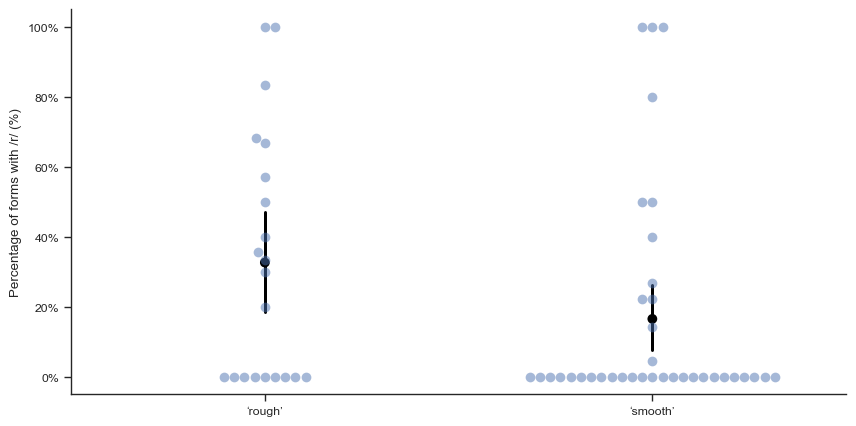

In [53]:
plt.figure(figsize=(10, 5)) # define the figure size
# plotting the swarmplot of the data (for visualization puproses)
sns.swarmplot(data=summary, x='Meaning', y='r', dodge=False, size = 7, alpha=0.5)
# plotting the mean of the data 
sns.pointplot(data=summary, x='Meaning', y='r', 
              estimator=np.mean, color='black', join=False,
              errorbar=('ci', 95))
# display y tickz with the percentage sign
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
# remove the x-axis label
plt.xlabel(None)
# set the y-axis label
plt.ylabel('Percentage of forms with /r/ (%)')
# remove the top and right spines (just for aesthetics)
sns.despine()
plt.show()

Great, we just reproduces Figure 3 from Winter et al. (2022)! However, it seems that there is a caweat in how they are plotting the data...

In [54]:
summary.head(10)

,Family,Trill,Meaning,r,Form
0,Austroasiatic,yes,‘rough’,57.142857,7.0
1,Austroasiatic,yes,‘smooth’,0.000000,6.0
2,Austronesian,yes,‘rough’,68.181818,22.0
3,Austronesian,yes,‘smooth’,22.222222,45.0
4,Barbacoan,yes,‘smooth’,0.000000,1.0
5,Benue-Congo,yes,‘rough’,100.000000,1.0
6,Benue-Congo,yes,‘smooth’,0.000000,1.0
7,Berber,yes,‘rough’,0.000000,1.0
8,Berber,yes,‘smooth’,0.000000,1.0
9,Central Solomons,yes,‘smooth’,0.000000,3.0


Let's look at the Barbacoan family:

In [55]:
summary[summary['Family'] == 'Barbacoan']

,Family,Trill,Meaning,r,Form
4,Barbacoan,yes,‘smooth’,0.0,1.0


There is ony one entry for this family, so we can't really say anything about it. We need to adjust it by adding a new entry. for the absence of trills.

In [56]:
def add_absenses(data):
    # ignore warnings
    for Family in data.Family.unique():
        if len(data[data.Family == Family]) == 1:
            # if there is a smooth form, add an absent form
            if "‘smooth’" in data[data.Family == Family].Meaning.values:
                new_entry = pd.DataFrame({'Family': [Family], 'Trill': ['yes'], 'Meaning': ["‘rough’"], 'r': [0], 'Form': [0]})
            else:
                new_entry = pd.DataFrame({'Family': [Family], 'Trill': ['yes'], 'Meaning': ["‘smooth’"], 'r': [0], 'Form': [0]})
            data = pd.concat([data, new_entry], ignore_index=True)

    return data

In [57]:
summary_w_absences = add_absenses(summary)

In [58]:
summary_w_absences[summary_w_absences['Family'] == 'Barbacoan']

,Family,Trill,Meaning,r,Form
4,Barbacoan,yes,‘smooth’,0.0,1.0
58,Barbacoan,yes,‘rough’,0.0,0.0


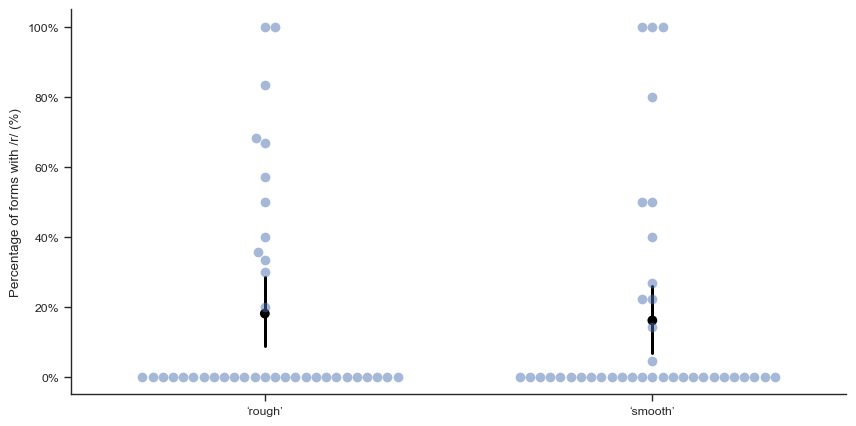

In [59]:
plt.figure(figsize=(10, 5)) # define the figure size
# plotting the swarmplot of the data (for visualization puproses)
sns.swarmplot(data=summary_w_absences, x='Meaning', y='r', dodge=False, size = 7, alpha=0.5)
# plotting the mean of the data 
sns.pointplot(data=summary_w_absences, x='Meaning', y='r', 
              estimator=np.mean, color='black', join=False,
              errorbar=('ci', 95))
# display y tickz with the percentage sign
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
# remove the x-axis label
plt.xlabel(None)
# set the y-axis label
plt.ylabel('Percentage of forms with /r/ (%)')
# remove the top and right spines (just for aesthetics)
sns.despine()
plt.show()

### 3.3. Analysing languages with different types of /r/

Let's create a new subset:

In [60]:
data_other_type = data[data.R_type_bin == 'other']

Now it's your turn, you need to recreate the same analysis as before, just for this new subset.

In [61]:
### YOUR ANSWER HERE ###